In [10]:
# Imports
import pandas as pd
import numpy as np

csv_file = '/Users/sumitkamra/code/sumitkamra20/expression_coding/data/icml_face_data.csv'

data = pd.read_csv(csv_file)
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [11]:
# Change the column names
data.columns = ['emotion', 'set', 'pixels']
data.set.value_counts()

set
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [15]:
def process_pixels(pixels_str, size=(48, 48)):
    pixel_values = np.array(pixels_str.split(), dtype=np.uint8)  # Split string by spaces and convert to uint8
    return pixel_values.reshape(size)  # Convert the flat array into a 2D array

data['pixels'] = data['pixels'].apply(process_pixels)


In [16]:
data.head()

,emotion,set,pixels
0,0,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,Training,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."


In [20]:
def split_dataset(df):
    # Split the data based on the 'Usage' column
    train_data = df[df['set'] == 'Training']
    val_data = df[df['set'] == 'PrivateTest']
    test_data = df[df['set'] == 'PublicTest']

    # Extract X and y for each set
    X_train = np.array(list(train_data['pixels']))
    y_train = train_data['emotion'].values
    X_val = np.array(list(val_data['pixels']))
    y_val = val_data['emotion'].values
    X_test = np.array(list(test_data['pixels']))
    y_test = test_data['emotion'].values

    return X_train, y_train, X_val, y_val, X_test, y_test


In [21]:
# Create a emotions dictionary
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Split the dataset
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(data)

In [52]:
# Normalize the data
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0



# Expand dimensions to fit the model input
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Let's check the shape of the data
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(28709, 48, 48, 1, 1) (28709,)
(3589, 48, 48, 1, 1) (3589,)
(3589, 48, 48, 1, 1) (3589,)


In [84]:
# Define a function to initialize the model with 3 convolutional layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def init_seq_model(l1 = 32, l2 = 64, l3 = 128, d1 = 64, d2 = 0.5):
    model = Sequential([
    # First convolutional layer
    Input(shape=(48, 48, 1)),  # Explicitely defining the input shape
    Conv2D(filters=l1, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer
    Conv2D(filters=l2, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer
    Conv2D(filters=l3, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flattening the 2D arrays for fully connected layers
    Flatten(),

    # Dense layer
    Dense(d1, activation='relu'),
    Dropout(d2),  # Dropout layer to reduce overfitting

    # Output layer
    Dense(7, activation='softmax')  # Assuming 7 different emotions/classes
    ])

    return model

#Lets define a function to create a model with n number of layers with specific parameters
def init_custom_cnn(n_layers=3, nodes=None, dense_nodes = 64, d1 = 0.5):
    if nodes == None:
        nodes = [32, 64, 128]
    if n_layers != len(nodes):
        raise ValueError("Number of layers and number of nodes should be equal")

    model = Sequential()
    model.add(Input(shape=(48, 48, 1)))
    for i in range(n_layers):
        model.add(Conv2D(filters=nodes[i], kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25)) # Add a dropout layer to reduce overfitting

    model.add(Flatten())

    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(d1))

    model.add(Dense(7, activation='softmax'))

    return model

#Lets define a function to create a model with n number of layers with specific parameters
def init_cnn_two_dense():
    model = Sequential()
    model.add(Input(shape=(48, 48, 1)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(7, activation='softmax'))

    return model


# Define function to compile the model
def compile_model(model, learning_rate=0.001):
    """
    Compiles the CNN model with an optimizer, loss function, and evaluation metrics.

    Parameters:
    - model: The uncompiled Keras model (Sequential).
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - The compiled model.
    """

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=SparseCategoricalCrossentropy(), # Suitable for integer-labeled targets
        metrics=['accuracy']
    )

    return model


In [80]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def fit_model(model, X_train, y_train, X_val, y_val,
              epochs=30, batch_size=64, patience=5):
    """
    Fits the model to the training data.

    Parameters:
    - model: The compiled Keras model to train.
    - X_train: Training data features (numpy array).
    - y_train: Training data labels (numpy array).
    - X_val: Validation data features (numpy array).
    - y_val: Validation data labels (numpy array).
    - epochs: Number of epochs to train the model. Default is 30.
    - batch_size: Batch size to use during training. Default is 64.

    Returns:
    - The history object containing training and validation loss and accuracy.
    """

    # Define early stopping callback
    early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00005,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]  # Add early stopping callback
    )

    # Run prediction of on the validation set
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=1)

    return history, y_pred

# Define a function to plot the training history
def plot_training_history(history):
    """
    Plots the training history of a Keras model.

    Parameters:
    - history: The history object returned from model.fit().

    Returns:
    - None; displays a plot of loss and accuracy metrics over each epoch.
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training & validation accuracy values
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    Parameters:
    - y_true: True labels of the data.
    - y_pred: Predicted labels of the data.
    - labels: List of class labels.

    Returns:
    - None; displays a confusion matrix plot.
    """

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame from the matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Create the plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot confusion matrix in percentage
    cm = confusion_matrix(y_val, y_pred, normalize='true')

    cm_percentage = cm * 100
    cm_percentage = pd.DataFrame(cm_percentage, index=labels, columns=labels)


    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues")
    plt.title('Confusion Matrix (%)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.2519 - loss: 1.8069 - val_accuracy: 0.2480 - val_loss: 1.7981
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.2505 - loss: 1.7968 - val_accuracy: 0.2923 - val_loss: 1.7195
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.2956 - loss: 1.7182 - val_accuracy: 0.3683 - val_loss: 1.5935
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.3653 - loss: 1.6062 - val_accuracy: 0.4202 - val_loss: 1.4924
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.3918 - loss: 1.5493 - val_accuracy: 0.4347 - val_loss: 1.4457
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4057 - loss: 1.4998 - val_accuracy: 0.4517 - val_loss: 1.4229
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4268 - loss: 1.4570 - val_accuracy: 0.4712 - val_loss: 1.3817
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4394 - loss: 1.4341 - 

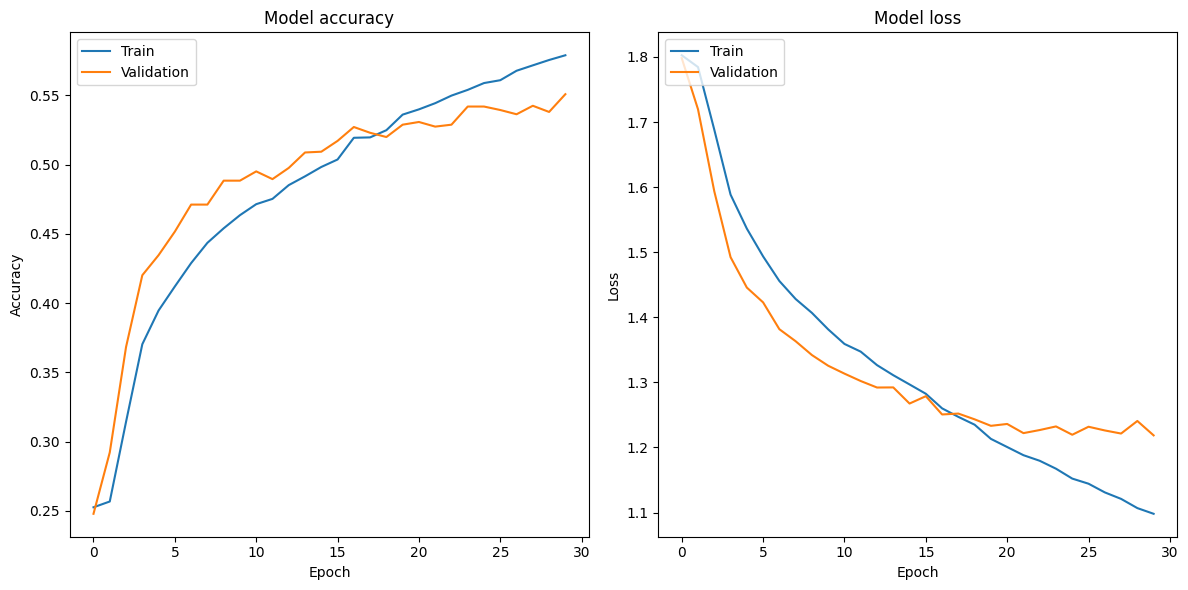

Training accuracy: 0.5789
Validation accuracy: 0.5508


In [53]:
model = init_custom_cnn()

# Let's train the model
history = fit_model(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=64)

# Plot the training history
plot_training_history(history)

# Display final training and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f'Training accuracy: {train_acc:.4f}')
print(f'Validation accuracy: {val_acc:.4f}')


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.2518 - loss: 1.8155 - val_accuracy: 0.3876 - val_loss: 1.5718
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.3833 - loss: 1.5789 - val_accuracy: 0.4394 - val_loss: 1.4448
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.4406 - loss: 1.4445 - val_accuracy: 0.4728 - val_loss: 1.3621
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.4644 - loss: 1.3922 - val_accuracy: 0.5026 - val_loss: 1.2967
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.4909 - loss: 1.3204 - val_accuracy: 0.5185 - val_loss: 1.2709
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5096 - loss: 1.2936 - val_accuracy: 0.5258 - val_loss: 1.2337
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5267 - loss: 1.2399 - val_accuracy: 0.5372 - val_loss: 1.2080
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5435 - loss: 1.2021 - 

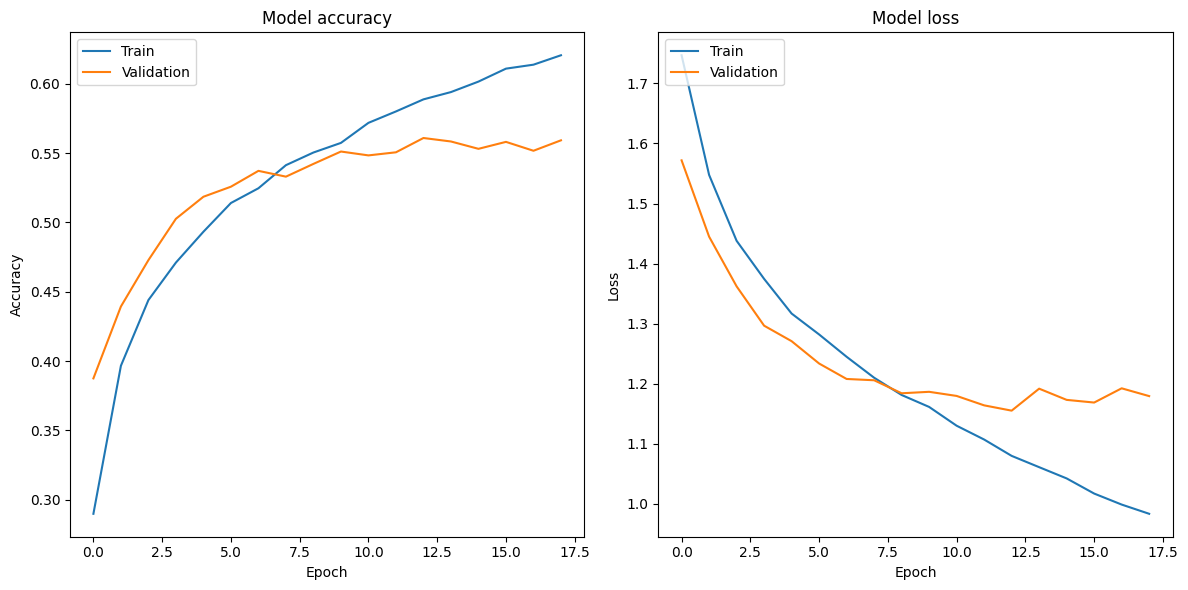

Training accuracy: 0.6205
Validation accuracy: 0.5592


In [62]:
# Initialize custom model with 3 layers to replicate what I did before
custom_model = init_custom_cnn()
custom_model = compile_model(custom_model)

# Train the custom model
custom_history, y_pred  = fit_model(custom_model, X_train, y_train, X_val, y_val, epochs=30, batch_size=64)

# Plot the training history
plot_training_history(custom_history)

# Print train and validation accuracy
print(f'Training accuracy: {custom_history.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy: {custom_history.history["val_accuracy"][-1]:.4f}')

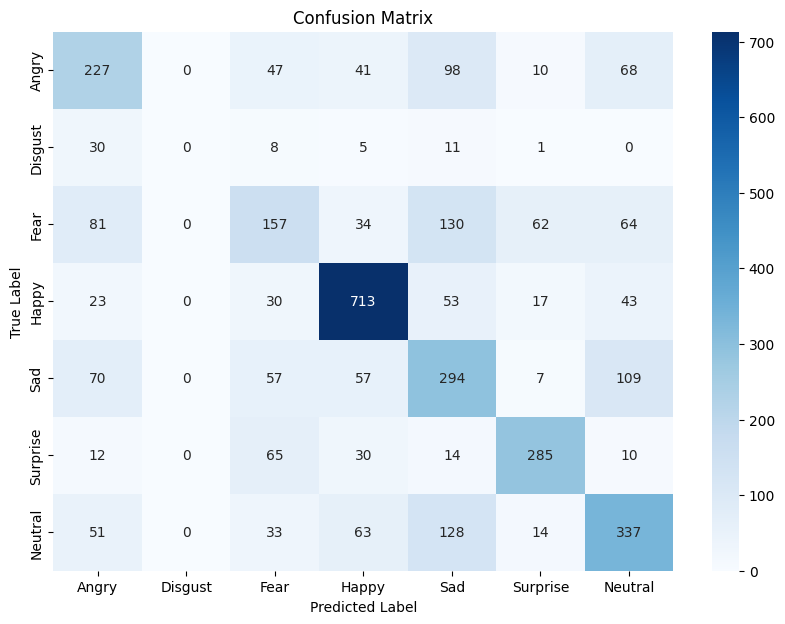

In [63]:
# Plot the confusion matrix
plot_confusion_matrix(y_val, y_pred, emotions.values())


In [66]:
# Print labels value_counts along with labels for training set
print(pd.DataFrame(y_train, columns=['emotion'])['emotion'].value_counts())
print(emotions)

# Print labels value_counts for validation set
print(pd.Series(y_val).value_counts())


emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
3    879
6    626
4    594
2    528
0    491
5    416
1     55
Name: count, dtype: int64


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2361 - loss: 1.8485 - val_accuracy: 0.3594 - val_loss: 1.6307
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.3539 - loss: 1.6474 - val_accuracy: 0.4333 - val_loss: 1.5115
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4025 - loss: 1.5410 - val_accuracy: 0.4639 - val_loss: 1.4250
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4319 - loss: 1.4651 - val_accuracy: 0.4854 - val_loss: 1.3780
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4614 - loss: 1.4115 - val_accuracy: 0.4951 - val_loss: 1.3402
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.4827 - loss: 1.3591 - val_accuracy: 0.5093 - val_loss: 1.2982
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.4963 - loss: 1.3247 - val_accuracy: 0.5202 - val_loss: 1.2746
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.5036 - loss: 1.3093 - 

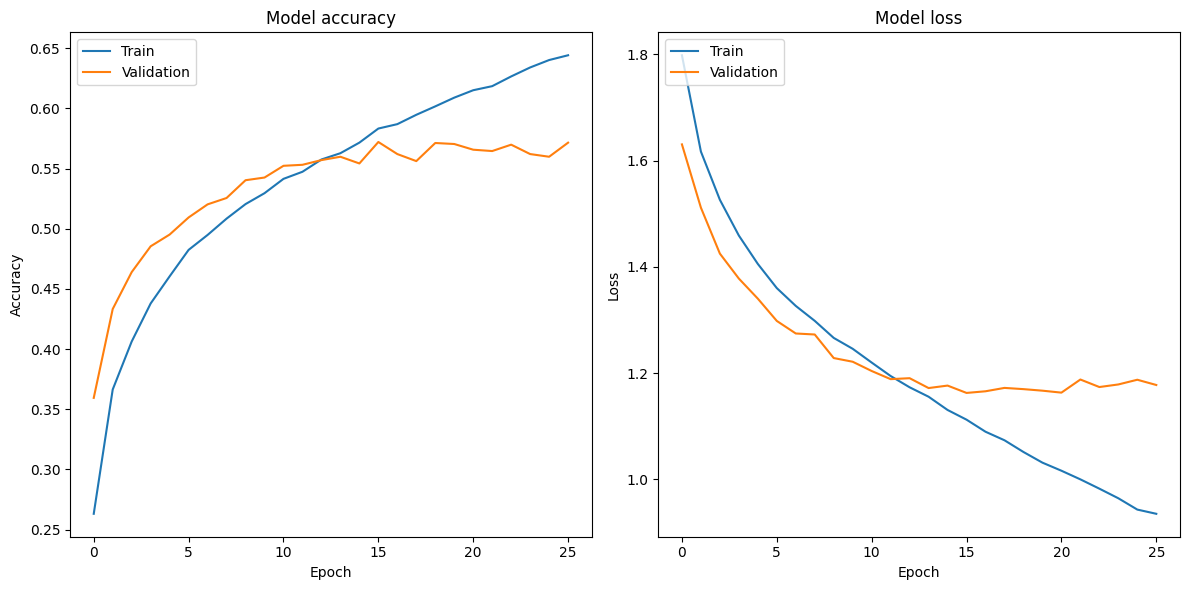

Training accuracy: 0.6441
Validation accuracy: 0.5715


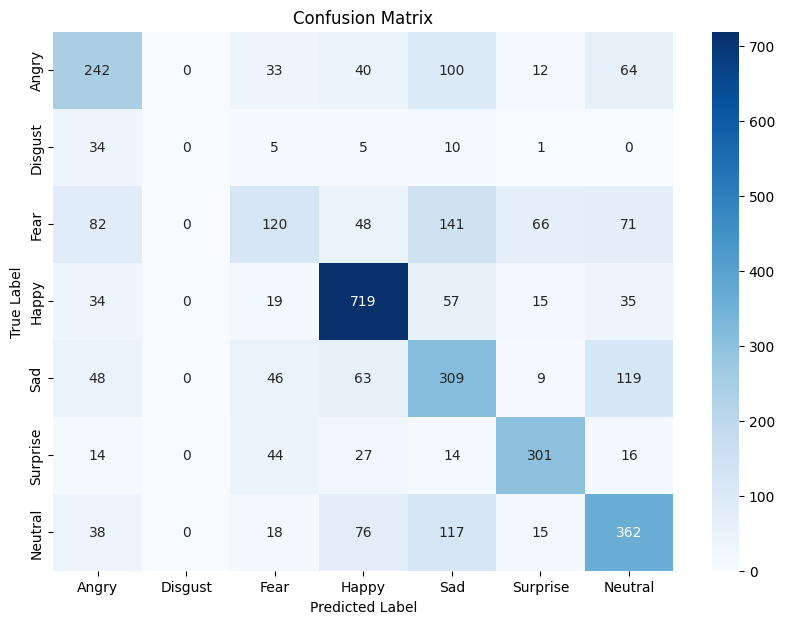

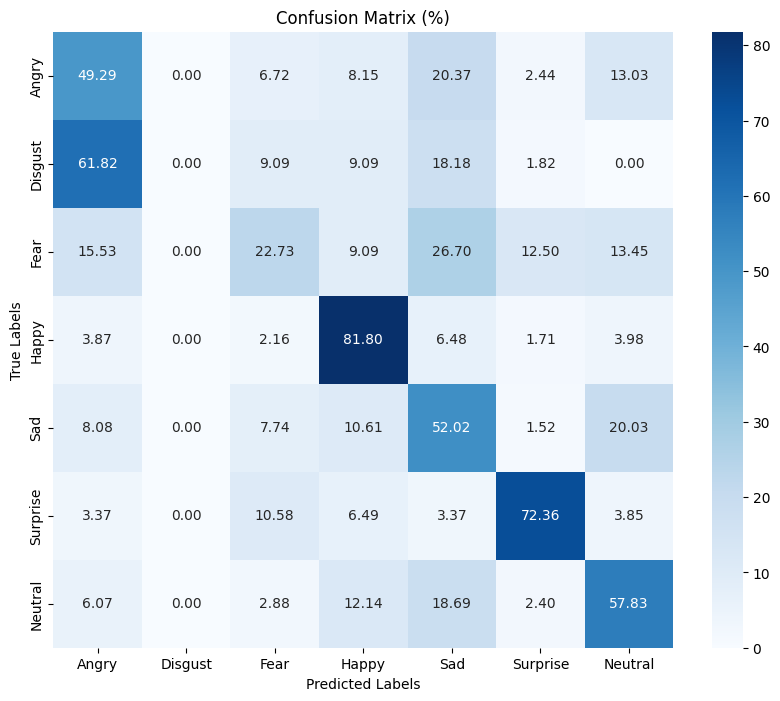

In [78]:
custom_model = init_custom_cnn()
custom_model = compile_model(custom_model, learning_rate=0.0005)

# Train the custom model
history, y_pred  = fit_model(custom_model, X_train, y_train,
                                    X_val, y_val,
                                    epochs=50, batch_size=64,
                                    patience=10)

# Plot the training history
plot_training_history(history)

# Print train and validation accuracy
print(f'Training accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy: {history.history["val_accuracy"][-1]:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_val, y_pred, emotions.values())

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.2423 - loss: 1.8344 - val_accuracy: 0.3583 - val_loss: 1.6881 - learning_rate: 5.0000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3508 - loss: 1.6561 - val_accuracy: 0.4238 - val_loss: 1.5032 - learning_rate: 5.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.3995 - loss: 1.5495 - val_accuracy: 0.4422 - val_loss: 1.4278 - learning_rate: 5.0000e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4452 - loss: 1.4463 - val_accuracy: 0.4859 - val_loss: 1.3474 - learning_rate: 5.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4741 - loss: 1.3792 - val_accuracy: 0.5060 - val_loss: 1.2954 - learning_rate: 5.0000e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4898 - loss: 1.3405 - val_accuracy: 0.5199 - val_loss: 1.2654 - learning_rate: 5.0000e-04
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/ste

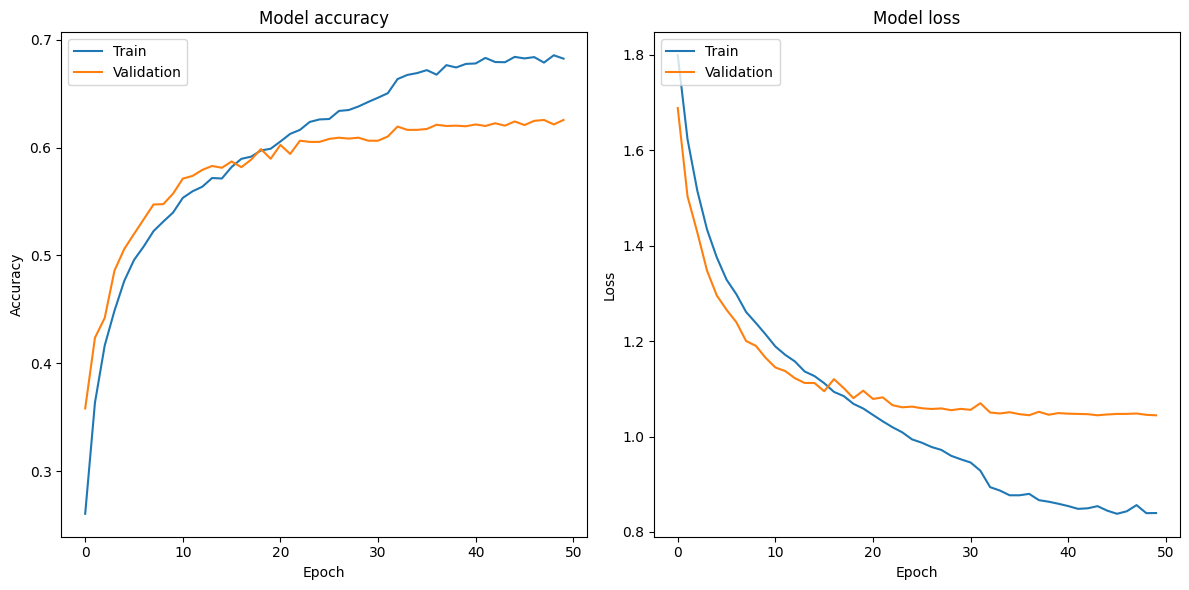

Training accuracy: 0.6823
Validation accuracy: 0.6255


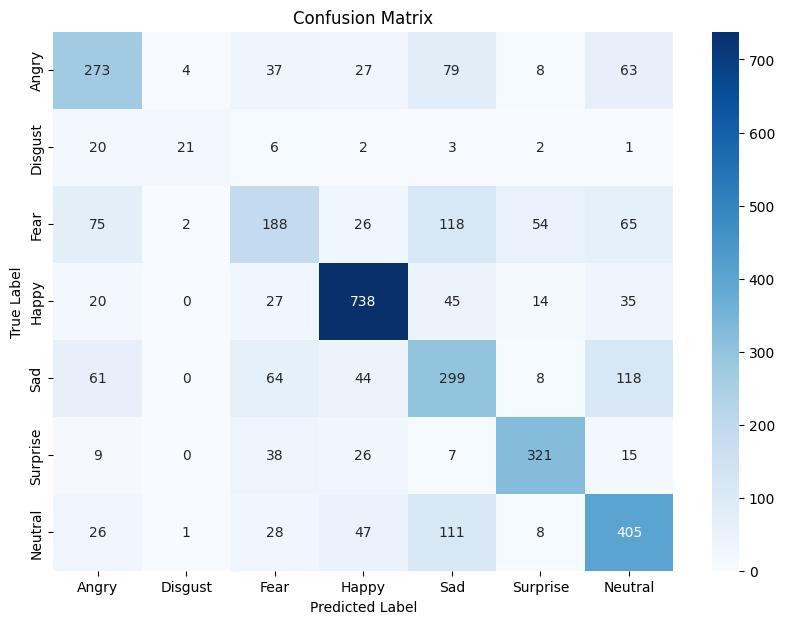

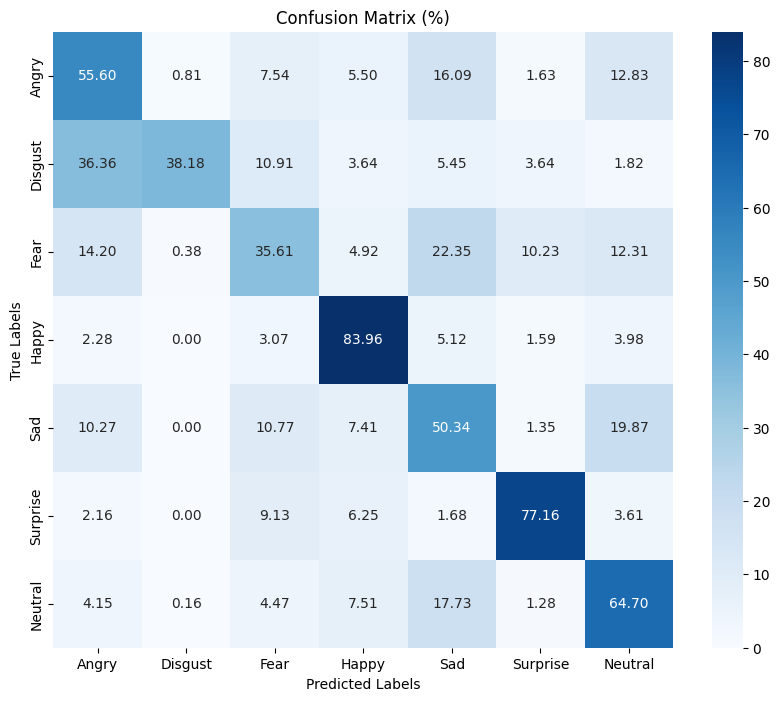

In [82]:
# Let's create a custom CNN with 3 layers and 64, 64, 128 nodes and 128 dense nodes
custom_cnn = init_custom_cnn(n_layers=3, nodes=[64, 64, 128], dense_nodes=128)
custom_cnn = compile_model(custom_cnn, learning_rate=0.0005)

# Train the custom model
history, y_pred  = fit_model(custom_cnn, X_train, y_train,
                                    X_val, y_val,
                                    epochs=50, batch_size=64,
                                    patience=10)

# Plot the training history
plot_training_history(history)

# Print train and validation accuracy
print(f'Training accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy: {history.history["val_accuracy"][-1]:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_val, y_pred, emotions.values())


Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 59s 130ms/step - accuracy: 0.2446 - loss: 1.8225 - val_accuracy: 0.2992 - val_loss: 1.7212 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 129ms/step - accuracy: 0.3304 - loss: 1.6681 - val_accuracy: 0.4386 - val_loss: 1.4474 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accuracy: 0.4262 - loss: 1.4769 - val_accuracy: 0.4804 - val_loss: 1.3285 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 129ms/step - accuracy: 0.4746 - loss: 1.3737 - val_accuracy: 0.4943 - val_loss: 1.3011 - learning_rate: 0.0010
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accuracy: 0.4953 - loss: 1.3177 - val_accuracy: 0.5247 - val_loss: 1.2121 - learning_rate: 0.0010
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - accuracy: 0.5145 - loss: 1.2672 - val_accuracy: 0.5436 - val_loss: 1.1807 - learning_rate: 0.0010
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accura

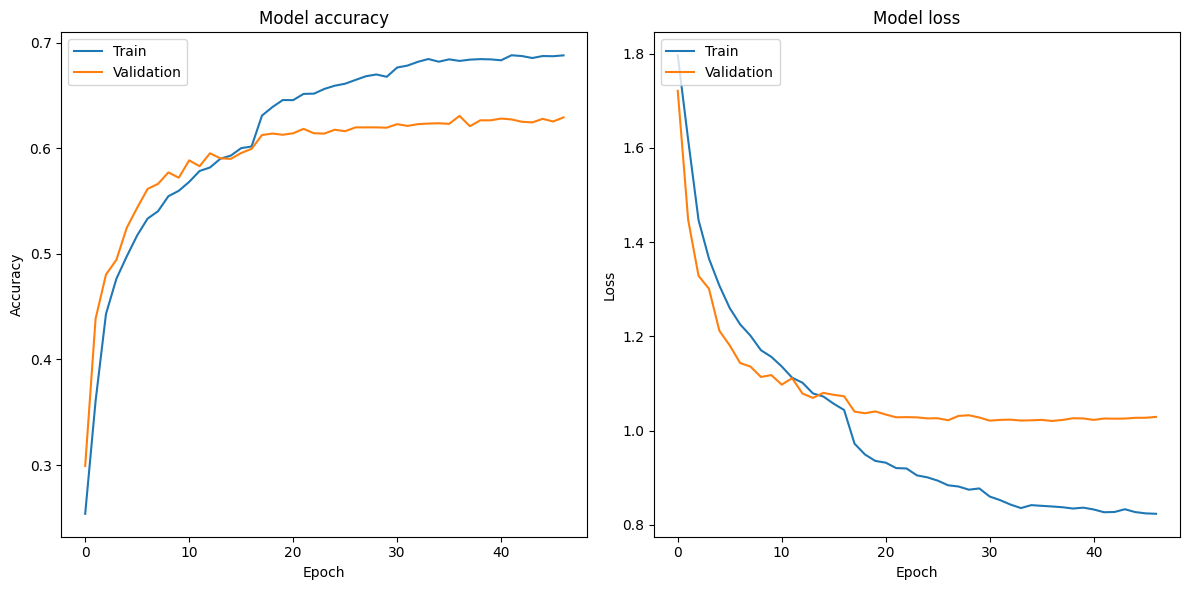

Training accuracy: 0.6878
Validation accuracy: 0.6291


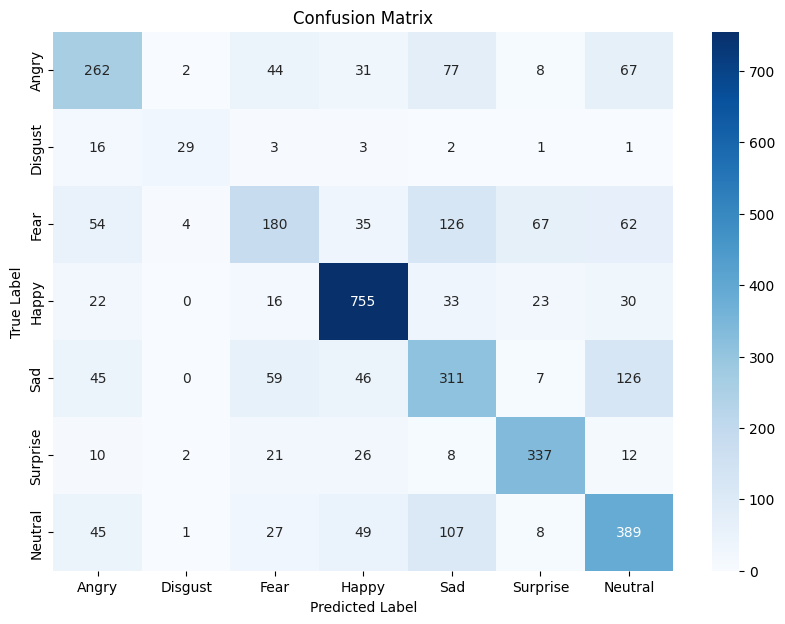

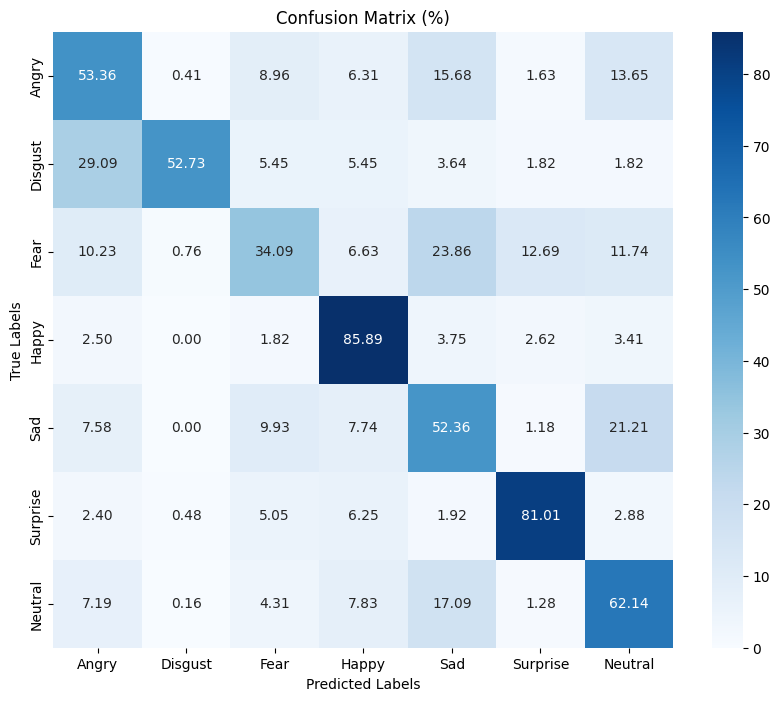

In [83]:
# Let's increase layers to 4 and nodes to 128, 128, 256, 256 with dense nodes 256

custom_cnn = init_custom_cnn(n_layers=4, nodes=[128, 128, 256, 256], dense_nodes=512)
custom_cnn = compile_model(custom_cnn, learning_rate=0.001)

# Train the custom model
history, y_pred  = fit_model(custom_cnn, X_train, y_train,
                                    X_val, y_val,
                                    epochs=100, batch_size=64,
                                    patience=10)

# Plot the training history
plot_training_history(history)

# Print train and validation accuracy
print(f'Training accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy: {history.history["val_accuracy"][-1]:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_val, y_pred, emotions.values())

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.2443 - loss: 1.8259 - val_accuracy: 0.2449 - val_loss: 1.8168 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 68s 152ms/step - accuracy: 0.2458 - loss: 1.8099 - val_accuracy: 0.3020 - val_loss: 1.7121 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 65s 145ms/step - accuracy: 0.3109 - loss: 1.7019 - val_accuracy: 0.3803 - val_loss: 1.5760 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 65s 144ms/step - accuracy: 0.3684 - loss: 1.6024 - val_accuracy: 0.4143 - val_loss: 1.4987 - learning_rate: 0.0010
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 64s 143ms/step - accuracy: 0.4057 - loss: 1.5300 - val_accuracy: 0.4283 - val_loss: 1.4754 - learning_rate: 0.0010
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 65s 144ms/step - accuracy: 0.4313 - loss: 1.4621 - val_accuracy: 0.4611 - val_loss: 1.3648 - learning_rate: 0.0010
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 64s 143ms/step - accura

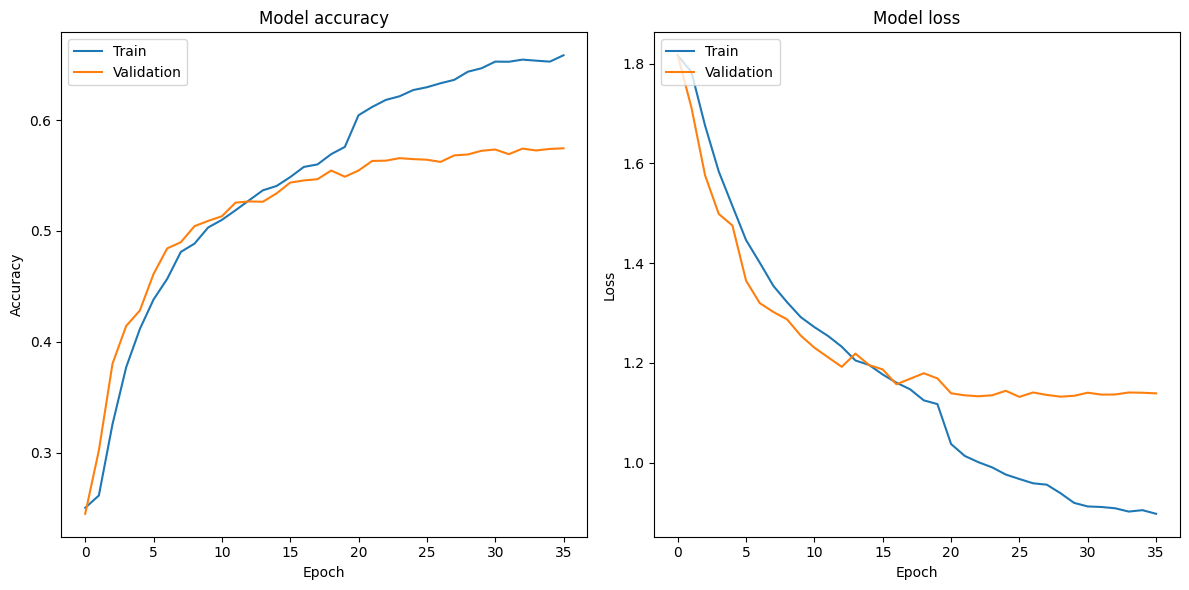

Training accuracy: 0.6584
Validation accuracy: 0.5745


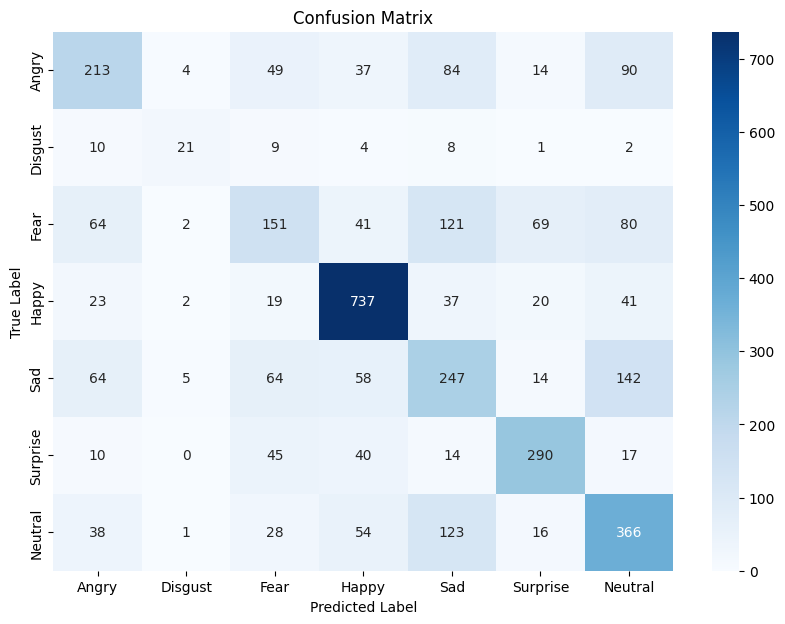

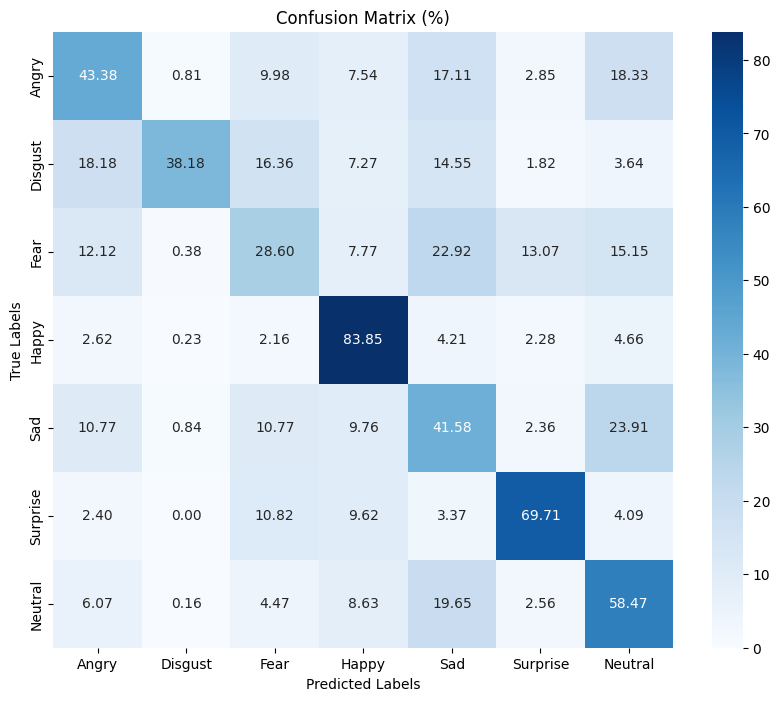

In [85]:
# 3 layers  64, 64, 128, dense nodes 1024

custom_cnn = init_cnn_two_dense()

custom_cnn = compile_model(custom_cnn, learning_rate=0.001)

# Train the custom model
history, y_pred  = fit_model(custom_cnn, X_train, y_train,
                                    X_val, y_val,
                                    epochs=100, batch_size=64,
                                    patience=10)

# Plot the training history
plot_training_history(history)

# Print train and validation accuracy
print(f'Training accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy: {history.history["val_accuracy"][-1]:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_val, y_pred, emotions.values())